In [53]:
import cv2
import os
## Extracting the frames from the video
cam = cv2.VideoCapture("vid1.mp4")
Frames_list = []

if not os.path.exists('Data_Frames'):
    os.makedirs('Data_Frames')

currentframe = 0

while(True):
    
    ret,frame = cam.read()
    if ret:
        name = './Data_Frames/frame' + str(currentframe) + '.jpg'
        print ('Creating...' + name)
        cv2.imwrite(name, frame)
        Frames_list.append(frame)
        currentframe += 1
    else:
            break
cam.release()
cv2.destroyAllWindows()


Creating..../Data_Frames/frame0.jpg
Creating..../Data_Frames/frame1.jpg
Creating..../Data_Frames/frame2.jpg
Creating..../Data_Frames/frame3.jpg
Creating..../Data_Frames/frame4.jpg
Creating..../Data_Frames/frame5.jpg
Creating..../Data_Frames/frame6.jpg
Creating..../Data_Frames/frame7.jpg
Creating..../Data_Frames/frame8.jpg
Creating..../Data_Frames/frame9.jpg
Creating..../Data_Frames/frame10.jpg
Creating..../Data_Frames/frame11.jpg
Creating..../Data_Frames/frame12.jpg
Creating..../Data_Frames/frame13.jpg
Creating..../Data_Frames/frame14.jpg
Creating..../Data_Frames/frame15.jpg
Creating..../Data_Frames/frame16.jpg
Creating..../Data_Frames/frame17.jpg
Creating..../Data_Frames/frame18.jpg
Creating..../Data_Frames/frame19.jpg
Creating..../Data_Frames/frame20.jpg
Creating..../Data_Frames/frame21.jpg
Creating..../Data_Frames/frame22.jpg
Creating..../Data_Frames/frame23.jpg
Creating..../Data_Frames/frame24.jpg
Creating..../Data_Frames/frame25.jpg
Creating..../Data_Frames/frame26.jpg
Creating...

In [54]:
import numpy as np
import cv2 as cv
import os
from numpy.linalg import norm, inv
from scipy.stats import multivariate_normal as mv_norm
from matplotlib import pyplot as plt

In [55]:
initial_weights = [0.75, 0.15, 0.06, 0.04] # initialising the weights of the guassians
init_mean = np.zeros(3) # initialising the means for RGB
threshold = 2.5 
K = 4
T = 0.9
init_sigma = 225*np.eye(3) 
init_alpha = 0.05

In [56]:
def compare(pixel, mean, sigma):
    d = norm(pixel-mean)
    sig = np.sqrt(sigma[0, 0])
    if d/sig < 2.5:  ## by this we can classify the pixel whether it belongs to this guassian or not
        return True
    else:
        return False

In [57]:
def training(init_alpha, K, threshold, initial_sigma, initial_mean, T, Frames_list):
    
    img_init = Frames_list[0] 
    img_shape = img_init.shape
 
    weight=np.array([[initial_weights for j in range(img_shape[1])] for i in range(img_shape[0])])
    mean=np.array([[[initial_mean for k in range(K)] for j in range(img_shape[1])]
                             for i in range(img_shape[0])])
    C = np.array([[[initial_sigma for k in range(K)] for j in range(img_shape[1])]
                             for i in range(img_shape[0])])
    Classifying_index = np.ones(img_shape[0:2], dtype=np.int)
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            for k in range(K):
                mean[i][j][k] = np.array(img_init[i][j]).reshape(1,3)
    foreground=[]
    image_index = 0
    for frame in Frames_list:
        print("frame_"+str(image_index))
        image_index = image_index+1
        img=frame
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                match=-1
                for k in range(K):
                    if compare(img[i][j], mean[i][j][k], C[i][j][k]): ## checking which guassian will it belong
                        match=k
                        break
                if match!=-1: ## if it is matching with some guassian and then update that pixel with the given formulas
                    mean1=mean[i][j][k]
                    C1=C[i][j][k]
                    x = img[i][j].astype(np.float)
                    delta=x-mean1
                    rho = init_alpha * mv_norm.pdf(img[i][j], mean1, C1)
                    weight[i][j] = (1 - init_alpha) * weight[i][j]
                    weight[i][j][match] += init_alpha
                    mean[i][j][k] = mean1 + rho * delta
                    C[i][j][k] = C1 + rho * (np.matmul(delta, delta.T) - C1)
                if match == -1:
                        w_list = [weight[i][j][k] for k in range(K)]
                        id = w_list.index(min(w_list))
                        mean[i][j][id] = np.array(img[i][j]).reshape(1, 3)
                        C[i][j][id] = np.array(initial_sigma)
        print('weight:{}'.format(weight[100][100]))
        
        for i in range(img_shape[0]):
            for j in range(img_shape[1]):
                k_weight = weight[i][j]
                k_norm = np.array([norm(np.sqrt(C[i][j][k])) for k in range(K)])
                ratio = k_weight/k_norm
                descending_order = np.argsort(-ratio)

                weight[i][j] = weight[i][j][descending_order]
                mean[i][j] = mean[i][j][descending_order]
                C[i][j] = C[i][j][descending_order]

                cum_weight = 0
                for index, order in enumerate(descending_order):
                    cum_weight += weight[i][j][index]
                    if cum_weight > T:
                        Classifying_index[i][j] = index + 1
                        break
                        
        
        ## Background_Subtraction
        img = frame
        result = np.array(img)

        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                for k in range(Classifying_index[i][j]):
                    if compare(img[i][j], mean[i][j][k], C[i][j][k]):
                        result[i][j] = [255, 255, 255]
                        break
        foreground.append(result)
        
    return foreground

In [58]:
foreground = training(init_alpha,K,threshold, init_sigma, init_mean, T,Frames_list)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15040\3250436921.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Classifying_index = np.ones(img_shape[0:2], dtype=np.int)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15040\3250436921.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: h

frame_0
weight:[0.7625 0.1425 0.057  0.038 ]
frame_1
weight:[0.774375 0.135375 0.05415  0.0361  ]
frame_2
weight:[0.78565625 0.12860625 0.0514425  0.034295  ]
frame_3
weight:[0.79637344 0.12217594 0.04887037 0.03258025]
frame_4
weight:[0.80655477 0.11606714 0.04642686 0.03095124]
frame_5
weight:[0.81622703 0.11026378 0.04410551 0.02940368]
frame_6
weight:[0.82541568 0.10475059 0.04190024 0.02793349]
frame_7
weight:[0.83414489 0.09951306 0.03980523 0.02653682]
frame_8
weight:[0.84243765 0.09453741 0.03781496 0.02520998]
frame_9
weight:[0.85031577 0.08981054 0.03592422 0.02394948]
frame_10
weight:[0.85779998 0.08532001 0.03412801 0.022752  ]
frame_11
weight:[0.86490998 0.08105401 0.03242161 0.0216144 ]
frame_12
weight:[0.87166448 0.07700131 0.03080052 0.02053368]
frame_13
weight:[0.87808126 0.07315125 0.0292605  0.019507  ]
frame_14
weight:[0.87808126 0.07315125 0.0292605  0.019507  ]
frame_15
weight:[0.87808126 0.07315125 0.0292605  0.019507  ]
frame_16
weight:[0.83417719 0.06949368 0.0

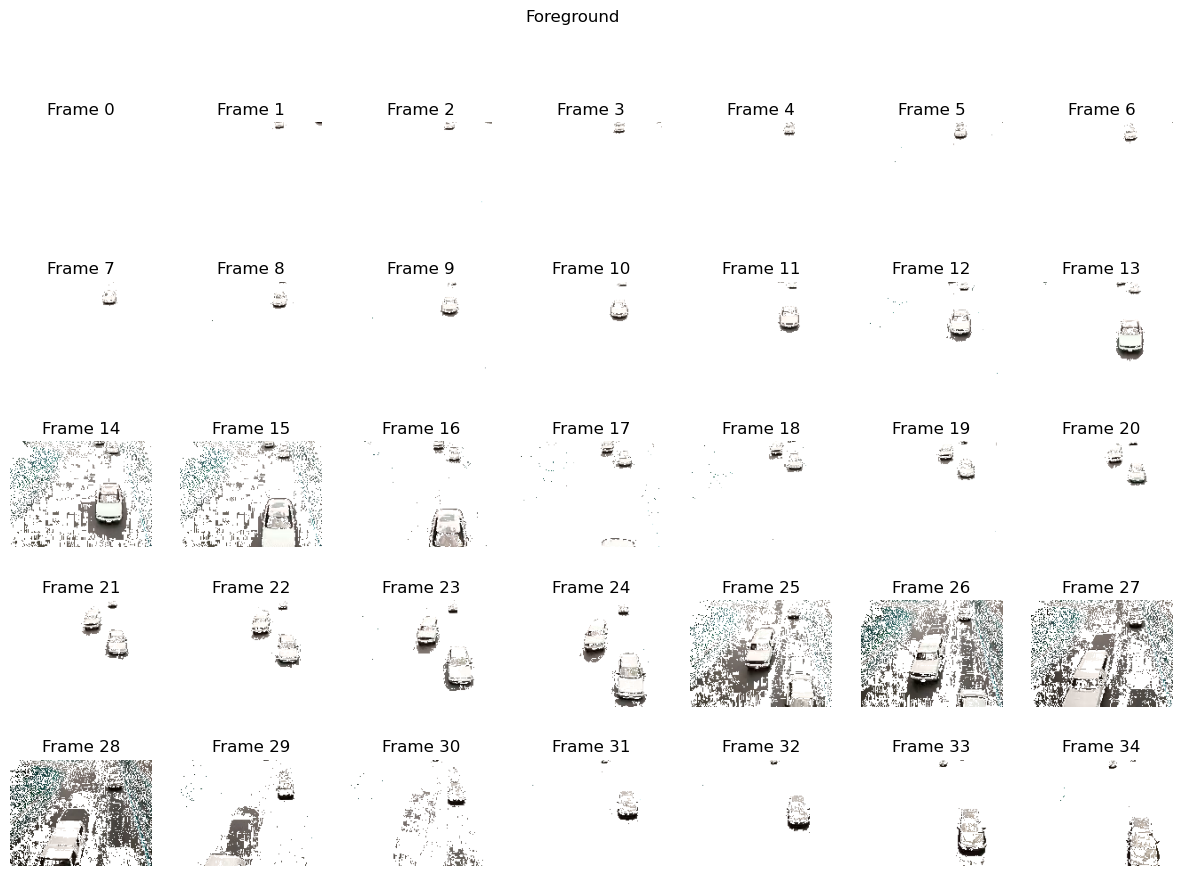

In [59]:
fig, axes = plt.subplots(5,7, figsize=(15, 10))
fig.suptitle("Foreground")
for i, ax in enumerate(axes.flat):
    ax.axis("off")
    ax.set_title("Frame "+str(i))
    ax.imshow(foreground[i])
plt.show()

In [62]:
import cv2
import os
def create_Video(foreground):
  image_folder = 'output/'
  video_name = 'output_vid.avi'

  height, width, layers = foreground[0].shape

  video = cv2.VideoWriter(video_name, 0, 1, (width,height))

  for i, image in enumerate(foreground):
      print(f"image {i}")
      video.write(image)

  cv2.destroyAllWindows()
  video.release()
create_Video(foreground)

image 0
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
image 28
image 29
image 30
image 31
image 32
image 33
image 34
image 35
image 36
image 37
image 38
image 39
image 40
image 41
image 42
image 43
image 44
image 45
image 46
image 47
image 48
image 49
image 50
image 51
image 52
image 53
image 54
image 55
image 56
image 57
image 58
image 59
image 60
image 61
image 62
image 63
image 64
image 65
image 66
image 67
image 68
image 69
image 70
image 71
image 72
image 73
image 74
image 75
image 76
image 77
image 78
image 79


In [64]:
import os

def convert_avi_to_mp4(avi_file_path, output_name):
    os.popen("ffmpeg -i '{input}' -ac 2 -b:v 2000k -c:a aac -c:v libx264 -b:a 160k -vprofile high -bf 0 -strict experimental -f mp4 '{output}.mp4'".format(input = avi_file_path, output = output_name))
    return True
convert_avi_to_mp4("output_vid.avi","output")

True

## Check the output video present in the file

In [87]:
import numpy as np
import cv2
cap = cv2.VideoCapture('vid1.mp4')
fgbg = cv2.createBackgroundSubtractorMOG2()

ForegroundInbuilt = []
while(True):
    ret, frame = cap.read()
 
    fgmask = fgbg.apply(frame)
    if ret == 0:
      break
    ForegroundInbuilt.append(fgmask)

     
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
     
 
cap.release()
cv2.destroyAllWindows()
print(np.array(foreground).shape)

bg = 0
bg_inbuilt = 0
for i in range(80):
  bg_count = 0
  bgInbuilt_count = 0
  for j in range(120):
    for k in range(160):
      if sum(foreground[i][j][k]) == 3*255 :
        bg_count += 1
      if ForegroundInbuilt[i][j][k] == 0 :
         bgInbuilt_count += 1
  bg += bg_count/(120*160)
  bg_inbuilt += bgInbuilt_count/(120*160)
accuracy= bg_inbuilt/bg
print(f"accuracy: {accuracy}")

(80, 120, 160, 3)
accuracy: 0.8404323020522453
